In [1]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

import openmc

In [2]:
#create materials

#fuel with realistic enrichment  (low density to simulate dispersed particles in aerogel)
fuel = openmc.Material(11, "Am242m")
fuel.add_nuclide('Am242_m1', .95)
fuel.add_nuclide('Am241', .05)
fuel.set_density('g/cm3', .136)
print(fuel)

#moderator
BeO = openmc.Material(2, "BeO")
BeO.add_nuclide("Be9", .5)
BeO.add_nuclide("O16", .5)
BeO.set_density("g/cm3", 2.86)
print(BeO)

#Be moderator
Be = openmc.Material(7, "Be")
Be.add_nuclide("Be9", 1.0)
Be.set_density("g/cm3", 1.85)
print(Be)

#"vacuum"
vac = openmc.Material(10, "H1")
vac.add_nuclide('H1',1.0)
vac.set_density('g/cm3',0.000001)
print(vac)

#reflector
#may add a reflector in the future. for now just BeO moderator

Material
	ID             =	11
	Name           =	Am242m
	Temperature    =	None
	Density        =	0.136 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	0.95         [ao]
	Am241          =	0.05         [ao]

Material
	ID             =	2
	Name           =	BeO
	Temperature    =	None
	Density        =	2.86 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.5          [ao]
	O16            =	0.5          [ao]

Material
	ID             =	7
	Name           =	Be
	Temperature    =	None
	Density        =	1.85 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	1.0          [ao]

Material
	ID             =	10
	Name           =	H1
	Temperature    =	None
	Density        =	1e-06 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	H1             =	1.0          [ao]



In [3]:
# Outer radius of fuel
fuel_outer = 1.4 #cm fuel outer radius
fuel_thickness = .1
fuel_inner = fuel_outer - fuel_thickness #inner radius for 2micron fuel layer

# parameters for depth of various things
fuel_depth = 60 #depth of fuel/moderator layer
ref_depth = 12 #depth of top reflecting/moderating layer

#edge length of hexagonal fuel cell
mod_thickness = 1.1
hex_dis = fuel_outer + mod_thickness
edge = hex_dis * 2 / np.sqrt(3)

#outer radius of fuel disk
disk_outer = 35 # radius in cm

mod_layers = 1

In [4]:
#specify useful geometric constants
origin_z = fuel_depth #specify the tip of the fuel cone to be in the center of the hexagon
theta = np.arctan(fuel_outer/fuel_depth) #half angle of the cone - useful for quadric
sep = fuel_thickness / np.sin(theta) #vertical separation between inner and outer fuel cone surfaces
Ap = -fuel_depth**2 / fuel_outer**2

#define a cell surface for a single fuel cylinder
f_inner_surf = openmc.Quadric(a = Ap, b=Ap, c=1, j=-2*(origin_z-sep),
                              k=(origin_z-sep)**2, boundary_type='transmission') #inner fuel surface
f_outer_surf = openmc.Quadric(a = Ap, b=Ap, c=1, j=-2*(origin_z),
                              k=(origin_z)**2, boundary_type='transmission') #outer fuel surface
f_lower_surf = openmc.ZPlane(z0=0, boundary_type="vacuum") #bottom planar layer
f_middle_surf = openmc.ZPlane(z0=fuel_depth-sep, boundary_type='transmission') #middle plane layer: at same z-coordinate as the vertex of fuel_inner surface cone
f_upper_surf = openmc.ZPlane(z0=fuel_depth, boundary_type="transmission") #boundary between fuel outer cone & top moderator layer
m_upper_surf = openmc.ZPlane(z0=fuel_depth+ref_depth, boundary_type="vacuum") #plane defining top boundary of moderator

outer_bound = openmc.ZCylinder(R=disk_outer+2*hex_dis, boundary_type="vacuum") #defines cylinder for outer universe of lattice

hex_region = openmc.get_hexagonal_prism(edge_length=edge, orientation='x', boundary_type="transmission") #hexagonal prism for lattice elements

hex_mod = +f_upper_surf & -m_upper_surf & hex_region #hegaonal prism region for moderator above the fuel region
hex_edge = +f_lower_surf & -m_upper_surf & hex_region #hexagonal region for entire fuel/moderator element

fuel_region1 = +f_outer_surf & -f_inner_surf & -f_middle_surf & +f_lower_surf #fuel region below inner fuel surface cone vertex
fuel_region2 = +f_outer_surf & +f_middle_surf & -f_upper_surf #fuel region above inner fuel surface vertex
fuel_region = fuel_region1 | fuel_region2 #union of both fuel regions for simpler code later
mod_region = -f_outer_surf & -f_upper_surf & +f_lower_surf & hex_region | hex_mod
vac_region = +f_inner_surf & -f_middle_surf & +f_lower_surf &~mod_region
medge_vac_region = hex_region & ~hex_edge

#fill the fuel region
f=openmc.Cell(1, 'fuel')
f.fill=fuel
f.region=fuel_region

#fill the moderator regions
m = openmc.Cell(2, 'moderator region 1')
m.fill=BeO
m.region=mod_region

medge = openmc.Cell(4, 'full plug hex')
medge.fill = BeO
medge.region = hex_edge

v = openmc.Cell(5, 'vacuum')
v.fill = vac
v.region = vac_region

v_medge = openmc.Cell(6, 'vacuum region for moderator edge element')
v_medge.fill = vac
v_medge.region = medge_vac_region

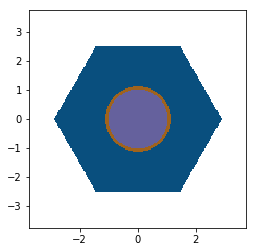

In [5]:
#visualize the fuel geometry
f_univ = openmc.Universe(cells=[f, m, v])
f_univ.plot(width=(3*hex_dis, 3*hex_dis), origin = (0,0,fuel_depth/5), basis='xy')

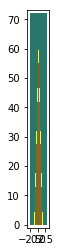

In [6]:
f_univ.plot(width=(3*hex_dis, fuel_depth+ref_depth+2), 
            origin = (0, 0, (fuel_depth+ref_depth)/2), basis='xz',
           color_by='material')

In [7]:
#f_univ.plot(width=(2*hex_dis, 1.75*ref_depth), 
#            origin = (0, 0, origin_z -sep), basis='xz', color_by='material')

In [8]:
edge_plug = openmc.Universe(cells=[medge])
#edge_plug.plot(width=(3*hex_dis, 1.5*(fuel_depth+ref_depth)), origin = (0,0,(fuel_depth+ref_depth)/2), basis='xz')

In [9]:
#define the outer universe
out_reg = +f_lower_surf & -m_upper_surf & -outer_bound
out = openmc.Cell(7, 'outer universe cell')
out.region = out_reg
out.fill = vac
outer_uni = openmc.Universe(cells=[out])

#create a hexagonal lattice geometry
hexag = openmc.HexLattice()
hexag.center = (0,0)
hexag.pitch = [2*hex_dis]
hexag.outer = outer_uni

#construct the fuel cell specification
#iterate the number of rings so to fill up disk cylinder
rings = 0
while 2*rings*2*hex_dis < 2*disk_outer:
    rings=rings+1

u = []
print(rings-mod_layers)
for i in range(rings,0,-1):
    if i == 1:
        num = 1
    else:
        num = (i-1)*6
    fill = []
    for j in range(0,num):
        if i > rings-mod_layers:
            fill.append(edge_plug)
        else:
            fill.append(f_univ)
    u.append(fill)

hexag.universes = u

6


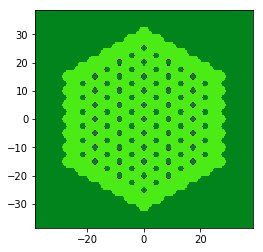

In [10]:
hex_cell = openmc.Cell(name='fuel disk')
hex_cell.fill = hexag

# Create final universe
uni = openmc.Universe(name='uni')
uni.add_cell(hex_cell)
uni.region = -outer_bound & +f_lower_surf & -m_upper_surf


uni.plot(width=(2.2*disk_outer, 2.2*disk_outer), origin = (0,0,(fuel_depth+ref_depth)/5), basis='xy', color_by='material')

In [11]:
#zoom in
#uni.plot(width=(5*hex_dis, 5*hex_dis), basis='xy', color_by='material')

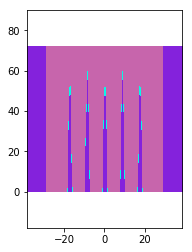

In [12]:
uni.plot(width=(2.2*disk_outer, 1.5*(fuel_depth+ref_depth)), origin=(0,0.01, (fuel_depth+ref_depth)/2),basis='xz', color_by='material')

In [13]:
#create root universe
geom = openmc.Geometry()
geom.root_universe = uni

#configure statistics geometry
#source = openmc.stats.Box((-20, -20, 0), (20, 20, fuel_depth))
r = fuel_inner / 2 + fuel_thickness / (np.cos(np.arcsin(fuel_inner/fuel_depth))) #place source halfway between inner and outer fuel layers
#theta = (2*np.pi) * np.random.rand()
theta = np.pi/2
source = openmc.stats.Point((r*np.cos(theta), r*np.sin(theta), fuel_depth/2))
src = openmc.Source(space=source)

#export geometry
geom.export_to_xml()

In [14]:
#create materials & cross sections xmls
mats = openmc.Materials()
mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
mats.append(fuel)
mats += [BeO]
mats += [Be]
mats += [vac]

#export materials
mats.export_to_xml()

In [15]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 100
settings.inactive = 10
settings.source = src
settings.export_to_xml()

In [16]:
#configure tallies
# Create mesh which will be used for tally
mesh = openmc.Mesh()
mesh.dimension = [300, 1, 300]
mesh.lower_left = [-disk_outer, -disk_outer, 0]
mesh.upper_right = [disk_outer, disk_outer, fuel_depth+ref_depth]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)

cell_filter = openmc.CellFilter(f)
t = openmc.Tally(4)
t.filters = [cell_filter, mesh_filter]
t.scores = ['fission', 'events']
tallies = openmc.Tallies([t])

#export tallies
tallies.export_to_xml()

In [17]:
openmc.run()

openmc: Relink `/home/james/anaconda3/bin/../lib/./libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               ####################

0

In [18]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

tally = sp.get_tally(scores=['events'])
print(tally)

Tally
	ID             =	4
	Name           =	
	Filters        =	CellFilter, MeshFilter
	Nuclides       =	total 
	Scores         =	['fission', 'events']
	Estimator      =	tracklength



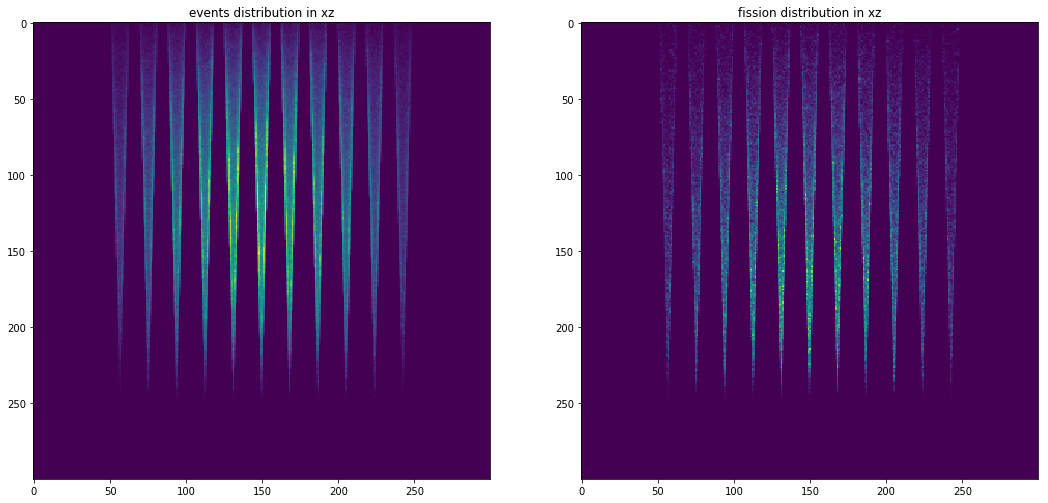

In [19]:
#plot where fissions & events are happening
events = tally.get_slice(scores=['events'])
fission = tally.get_slice(scores=['fission'])

events.std_dev.shape = (300, 300)
events.mean.shape = (300, 300)
fission.std_dev.shape = (300, 300)
fission.mean.shape = (300, 300)

width = 18
height = 18
plt.figure(figsize=(width, height))

fig = plt.subplot(121)
fig.set_title('events distribution in xz')
fig.imshow(events.mean)
fig2 = plt.subplot(122)
fig2.set_title('fission distribution in xz')
fig2.imshow(fission.mean)

In [20]:
def rep_cone_mass(rings, fuel_depth, fuel_outer, edge_length, ref_depth, mod_dens) :
    """
    Calculates the mass of a repeating cylinder geometry
    
    Inputs:
    Rings: number of rings of fuel/moderator hexagonal prisms
    fuel_depth: height of the fuel/moderator section
    fuel_outer: outer radius of fuel layer
    edge_length: edge length of hexagonal prisms
    ref_depth: height of moderator layer
    mod_dens: density in g/cm3 of moderating material
    
    Outputs:
    mass: mass of the engine in kg
    """
    
    mod_plugs = 0 #number of hexagonal prisms filled just with moderator
    fuel_plugs = 1 #number of hexagonal prisms with moderator, fuel, & vacuum
    for i in range(1, rings-mod_layers+1) : #determine number of hexagonal prisms with fuel
        fuel_plugs += i*6
    for i in range(rings-mod_layers+1, rings):
        mod_plugs += i*6
        
    modV = (fuel_depth+ref_depth)*3*np.sqrt(3)*edge_length**2 / 2 #volume of a moderator plug
    fuelV = (ref_depth*3*np.sqrt(3)*edge_length**2 / 2) + \
            fuel_depth*3*np.sqrt(3)*edge_length**2 / 2 - \
            np.pi*fuel_outer*(fuel_outer+np.sqrt(fuel_depth**2+fuel_outer**2)) #volume of a fuel plug
    
    #add up all of the masses
    mass = mod_dens * (mod_plugs*modV + fuel_plugs*fuelV) / 1000
    
    return mass

In [21]:
rep_cone_mass(rings, fuel_depth, fuel_outer, edge, ref_depth, 2.86)

468.08982071350687